# Descriptive fit analysis

Last access (y.m.d): 19.06.13  
Last update (y.m.d): ??

Unlike descrAnalysisV1-allExps, this notebook only deals with one experiment at a time.

### Here, I'll look at the descriptive fits to both experimental and simulated/model data to read off and analyze SF tuning properties

In [882]:
import warnings
warnings.filterwarnings('once')

In [852]:
import numpy as np
import os
import helper_fcns as hf
from scipy.stats.mstats import gmean
import itertools
import autoreload
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline

# expDir = 'V1_orig/'
# expName = 'dataList.npy';
expDir = 'V1/'
expName = 'dataList_glx.npy';
fitName = 'fitList_190502cA_wght_chiSq.npy';
# fitName = 'fitListSPcns_181130c_wght_chiSq.npy';
descrName = 'descrFits_190503_poiss_flex.npy';
rvcName   = 'rvcFits_f0.npy'
# descrModName = 'descrFitsModel.npy';
# respName = 'respAboveBase.npy';

base_dir = os.getcwd() + '/';
data_loc = base_dir + expDir + 'structures/';
save_loc = base_dir + expDir + 'figures/';

muLoc = 2; # mu is in location '2' of parameter arrays
c50Loc = 2; # c50 is in location 2 of parameter arrays

In [853]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.style'] = 'oblique'
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues

In [854]:
dataList = hf.np_smart_load(data_loc + expName);

expInd = hf.get_exp_ind(data_loc, dataList['unitName'][-1])[0]
expInf = hf.get_exp_params(expInd);

useLowRespCut = 1; # should you filter the data based on analysis in "Considering responsivity..."

height = 3/4; # measure BW at half-height
sf_range = [0.01, 10]; # allowed values of 'mu' for fits - see descr_fit.py for details

In [855]:
### sf tuning
descrExp = hf.np_smart_load(data_loc + descrName)
# HACKY: Just setting to descrFits on exp data...
descrMod = hf.np_smart_load(data_loc + descrName)
# descrMod = np.load(data_loc + descrModName, encoding='latin1').item()

### rvc
rvcExp = hf.np_smart_load(data_loc + rvcName)
# HACKY: Just setting to descrFits on exp data...
rvcMod = hf.np_smart_load(data_loc + rvcName)

In [856]:
modParams = np.load(data_loc + fitName, encoding='latin1').item();

### Get bandwidth/prefSf measures organized

In [857]:
# get experiment parameters/organization
nCells = len(dataList['unitName']);

maxComp = np.zeros((3,), dtype=int); # i.e.

for f in dataList['unitName']:
    
    cell = hf.np_smart_load(data_loc + f + '_sfm.npy');
    expInd = hf.get_exp_ind(data_loc, f)[0];
    _, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(cell, expInd);

    for currComp, i in zip(stimVals, range(len(stimVals))):
        if len(currComp) > maxComp[i]:
            maxComp[i] = len(currComp);  

# now we know the maximum number of dispersions, sfs, and contrasts

In [860]:
nFamiliesMax, nConsMax, nSfsMax = maxComp;

bwMod = np.zeros((nCells, nFamiliesMax, nConsMax)) * np.nan;
bwExp = np.zeros((nCells, nFamiliesMax, nConsMax)) * np.nan;

pSfMod = np.zeros((nCells, nFamiliesMax, nConsMax)) * np.nan;
pSfExp = np.zeros((nCells, nFamiliesMax, nConsMax)) * np.nan;

c50Mod = np.zeros((nCells, nFamiliesMax, nSfsMax)) * np.nan
c50Exp = np.zeros((nCells, nFamiliesMax, nSfsMax)) * np.nan

In [861]:
for i in descrExp:
    for f in range(nFamilies):
        # spatial frequency stuff
        for c in range(nCons):
        
            if i in descrExp:
                try:
                    # on data
                    ignore, bwExp[i, f, c] = hf.compute_SF_BW(descrExp[i]['params'][f, c, :], height, sf_range)
                    pSfExp[i, f, c] = descrExp[i]['params'][f, c, muLoc]
                except: # then this dispersion does not have that contrast value, but it's ok - we already have nan
                    pass 

            if i in descrMod:
                try:
                    # on model
                    ignore, bwMod[i, f, c] = hf.compute_SF_BW(descrMod[i]['params'][f, c, :], height, sf_range)
                    pSfMod[i, f, c] = descrMod[i]['params'][f, c, muLoc]
                except: # then this dispersion does not have that contrast value, but it's ok - we already have nan
                    pass

        # RVC stuff
        for s in range(nSfs):
            if i in rvcExp:
                # on data
                try:
                    c50Exp[i, f, s] = rvcExp[i]['params'][d, s, c50Loc];
                except: # then this dispersion does not have that SF value, but it's ok - we already have nan
                    pass
                
            if i in rvcMod:
                # on model
                try:
                    c50Mod[i, f, s] = rvcMod[i]['params'][d, s, c50Loc];
                except: # then this dispersion does not have that SF value, but it's ok - we already have nan
                    pass

In [862]:
bwModRats = np.zeros((nCells, nFamilies, nCons, nCons)) * np.nan;
bwExpRats = np.zeros((nCells, nFamilies, nCons, nCons)) * np.nan;

pSfModRats = np.zeros((nCells, nFamilies, nCons, nCons)) * np.nan;
pSfExpRats = np.zeros((nCells, nFamilies, nCons, nCons)) * np.nan;

c50ModRats = np.zeros((nCells, nFamilies, nSfs, nSfs)) * np.nan;
c50ExpRats = np.zeros((nCells, nFamilies, nSfs, nSfs)) * np.nan;

In [863]:
for i in descrExp:
    for f in range(nFamilies):
        # as function of contrast
        for comb in itertools.combinations(range(nCons), 2):
            bwModRats[i,f,comb[0],comb[1]] = bwMod[i,f,comb[1]] - bwMod[i,f,comb[0]]
            bwExpRats[i,f,comb[0],comb[1]] = bwExp[i,f,comb[1]] - bwExp[i,f,comb[0]]

            pSfModRats[i,f,comb[0],comb[1]] = pSfMod[i,f,comb[1]] / pSfMod[i,f,comb[0]]
            pSfExpRats[i,f,comb[0],comb[1]] = pSfExp[i,f,comb[1]] / pSfExp[i,f,comb[0]]

        # as function of SF
        for comb in itertools.permutations(range(nSfs), 2):
            c50ModRats[i,f,comb[0],comb[1]] = c50Mod[i,f,comb[1]] / c50Mod[i,f,comb[0]]
            c50ExpRats[i,f,comb[0],comb[1]] = c50Exp[i,f,comb[1]] / c50Exp[i,f,comb[0]]

### Organize model-derived ratio

Rather than taking just the data, we can restrict ourselves to well-fit (i.e. varExpl > a set threshold) tuning curves; read off the variable of interest (e.g. prefSf) for that curve, and fit a model to the progression of that variable with , e.g. contrast -- finally, read off the variable of interest from the model, rather than just the point/discrete values

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


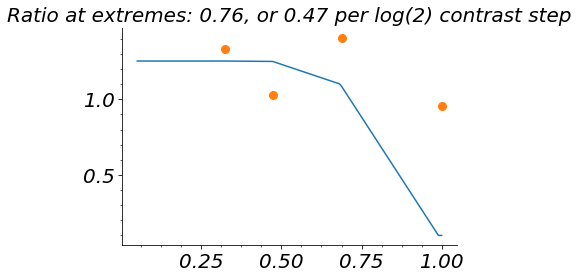

In [865]:
### Plot + compute pSfRatio in a model-derived way (i.e. use all prefSfs at different cons, fit a model and read off)
# for individual cell

varThresh = 80;
cellNum = 4;
disp = 0;

name = dataList['unitName'][cellNum-1];
expInd = hf.get_exp_ind(data_loc, name)[0];
cell = hf.np_smart_load(data_loc + name + '_sfm.npy')
_, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(cell, expInd);
all_cons = stimVals[1];
nFamilies = len(stimVals[0]);


pSfRatio, psf_model, opt_params = hf.dog_prefSfMod(descrExp[cellNum-1], allCons=all_con, disp=disp, varThresh=varThresh, dog_model=0)

valInds = np.where(descrExp[cellNum-1]['varExpl'][disp, :] > varThresh)[0];
logConRat = np.log2(all_con[valInds[-1]]/all_con[valInds[0]]);
plt.plot(all_con, psf_model(*opt_params, con=all_con))
plt.plot(all_con[valInds], pSfExp[cellNum-1, disp, valInds], 'o')
plt.title('Ratio at extremes: %.2f, or %.2f per log(2) contrast step' % (pSfRatio, pSfRatio/logConRat));

In [866]:
### Compute pSfRatio in a model-derived way (i.e. use all prefSfs at different cons, fit a model and read off)

varThresh = 80;
pSfDerivRats = np.zeros((nCells, nFamilies, 2)) * np.nan

for f, ind in zip(dataList['unitName'], range(nCells)):
    
    expInd = hf.get_exp_ind(data_loc, f)[0];
    cell = hf.np_smart_load(data_loc + f + '_sfm.npy')
    _, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(cell, expInd);
    all_cons = stimVals[1];
    nFamilies = len(stimVals[0]);
    
    for disp in range(nFamilies):

        try:
            pSfRatio, psf_model, opt_params = hf.dog_prefSfMod(descrExp[ind], allCons=all_con, disp=disp, varThresh=varThresh, dog_model=0)

            valInds = np.where(descrExp[ind]['varExpl'][disp, :] > varThresh)[0];
            logConRat = np.log2(all_con[valInds[-1]]/all_con[valInds[0]]);

            pSfDerivRats[ind, disp, :] = [pSfRatio, np.log2(pSfRatio)/logConRat]
        except:
            pass # then either fit doesn't exist or no SF descr fits passed thresh; we've already initialized to nan

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:960: RuntimeWarning: invalid value encountered in double_scalars
  init_slope = (prefSfs[-1] - prefSfs[0]) / conRange;


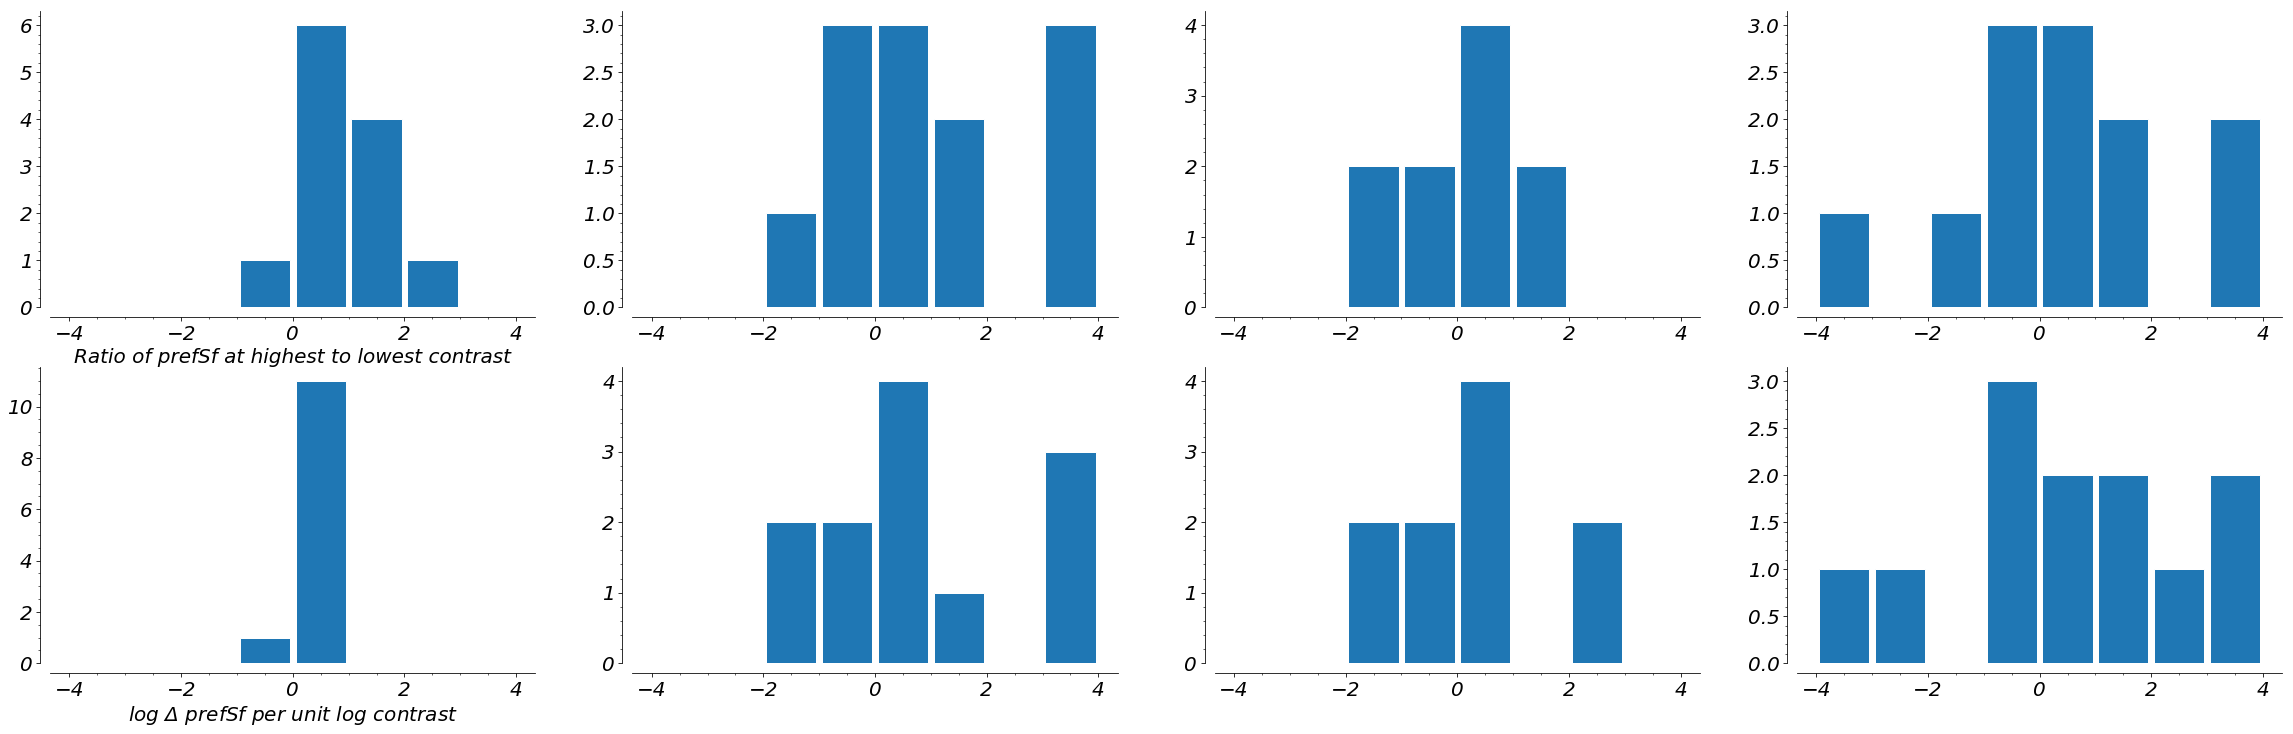

In [867]:
f, ax = plt.subplots(2, nFamiliesMax, figsize=(10*nFamiliesMax, 12));

binsRat = np.linspace(-4,4,9)
binsUnit = np.linspace(-4,4,9)

for i in range(nFamiliesMax):

    nonNan = np.where(~np.isnan(pSfDerivRats[:, i, 0]))
    ax[0, i].hist(np.clip(np.log2(pSfDerivRats[nonNan, i, 0][0]), binsRat[0], binsRat[-1]), bins=binsRat, rwidth=0.9)
    if i == 0:
        ax[0, i].set_xlabel('Ratio of prefSf at highest to lowest contrast')
    
    ax[1, i].hist(np.clip(pSfDerivRats[nonNan, i, 1][0], binsUnit[0], binsUnit[-1]), bins=binsUnit, rwidth=0.9)
    if i == 0:
        ax[1, i].set_xlabel(r'log $\Delta$ prefSf per unit log contrast')

sns.despine(offset=10)

### Ratio plots as matricies (i.e. all relevant pairwise ratios)

Now, we compute all pairwise combinations so that we can compute the ratios/differences of these measures.
- For the pSf/BW, which we measure at distinct contrasts, we want to take the ratio as relative to the higher contrast, which is the larger index into all_cons
- For the c50 measure, this is a function of SF; we'll eventually want to take the ratios relative to the preferred (or closest-to-preferred) SF

In [868]:
pSfExp.shape

(17, 4, 18)

In [869]:
pSfExp[ind, 0, -1]

3.42671309465012

### now, example "upper diag plots"

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


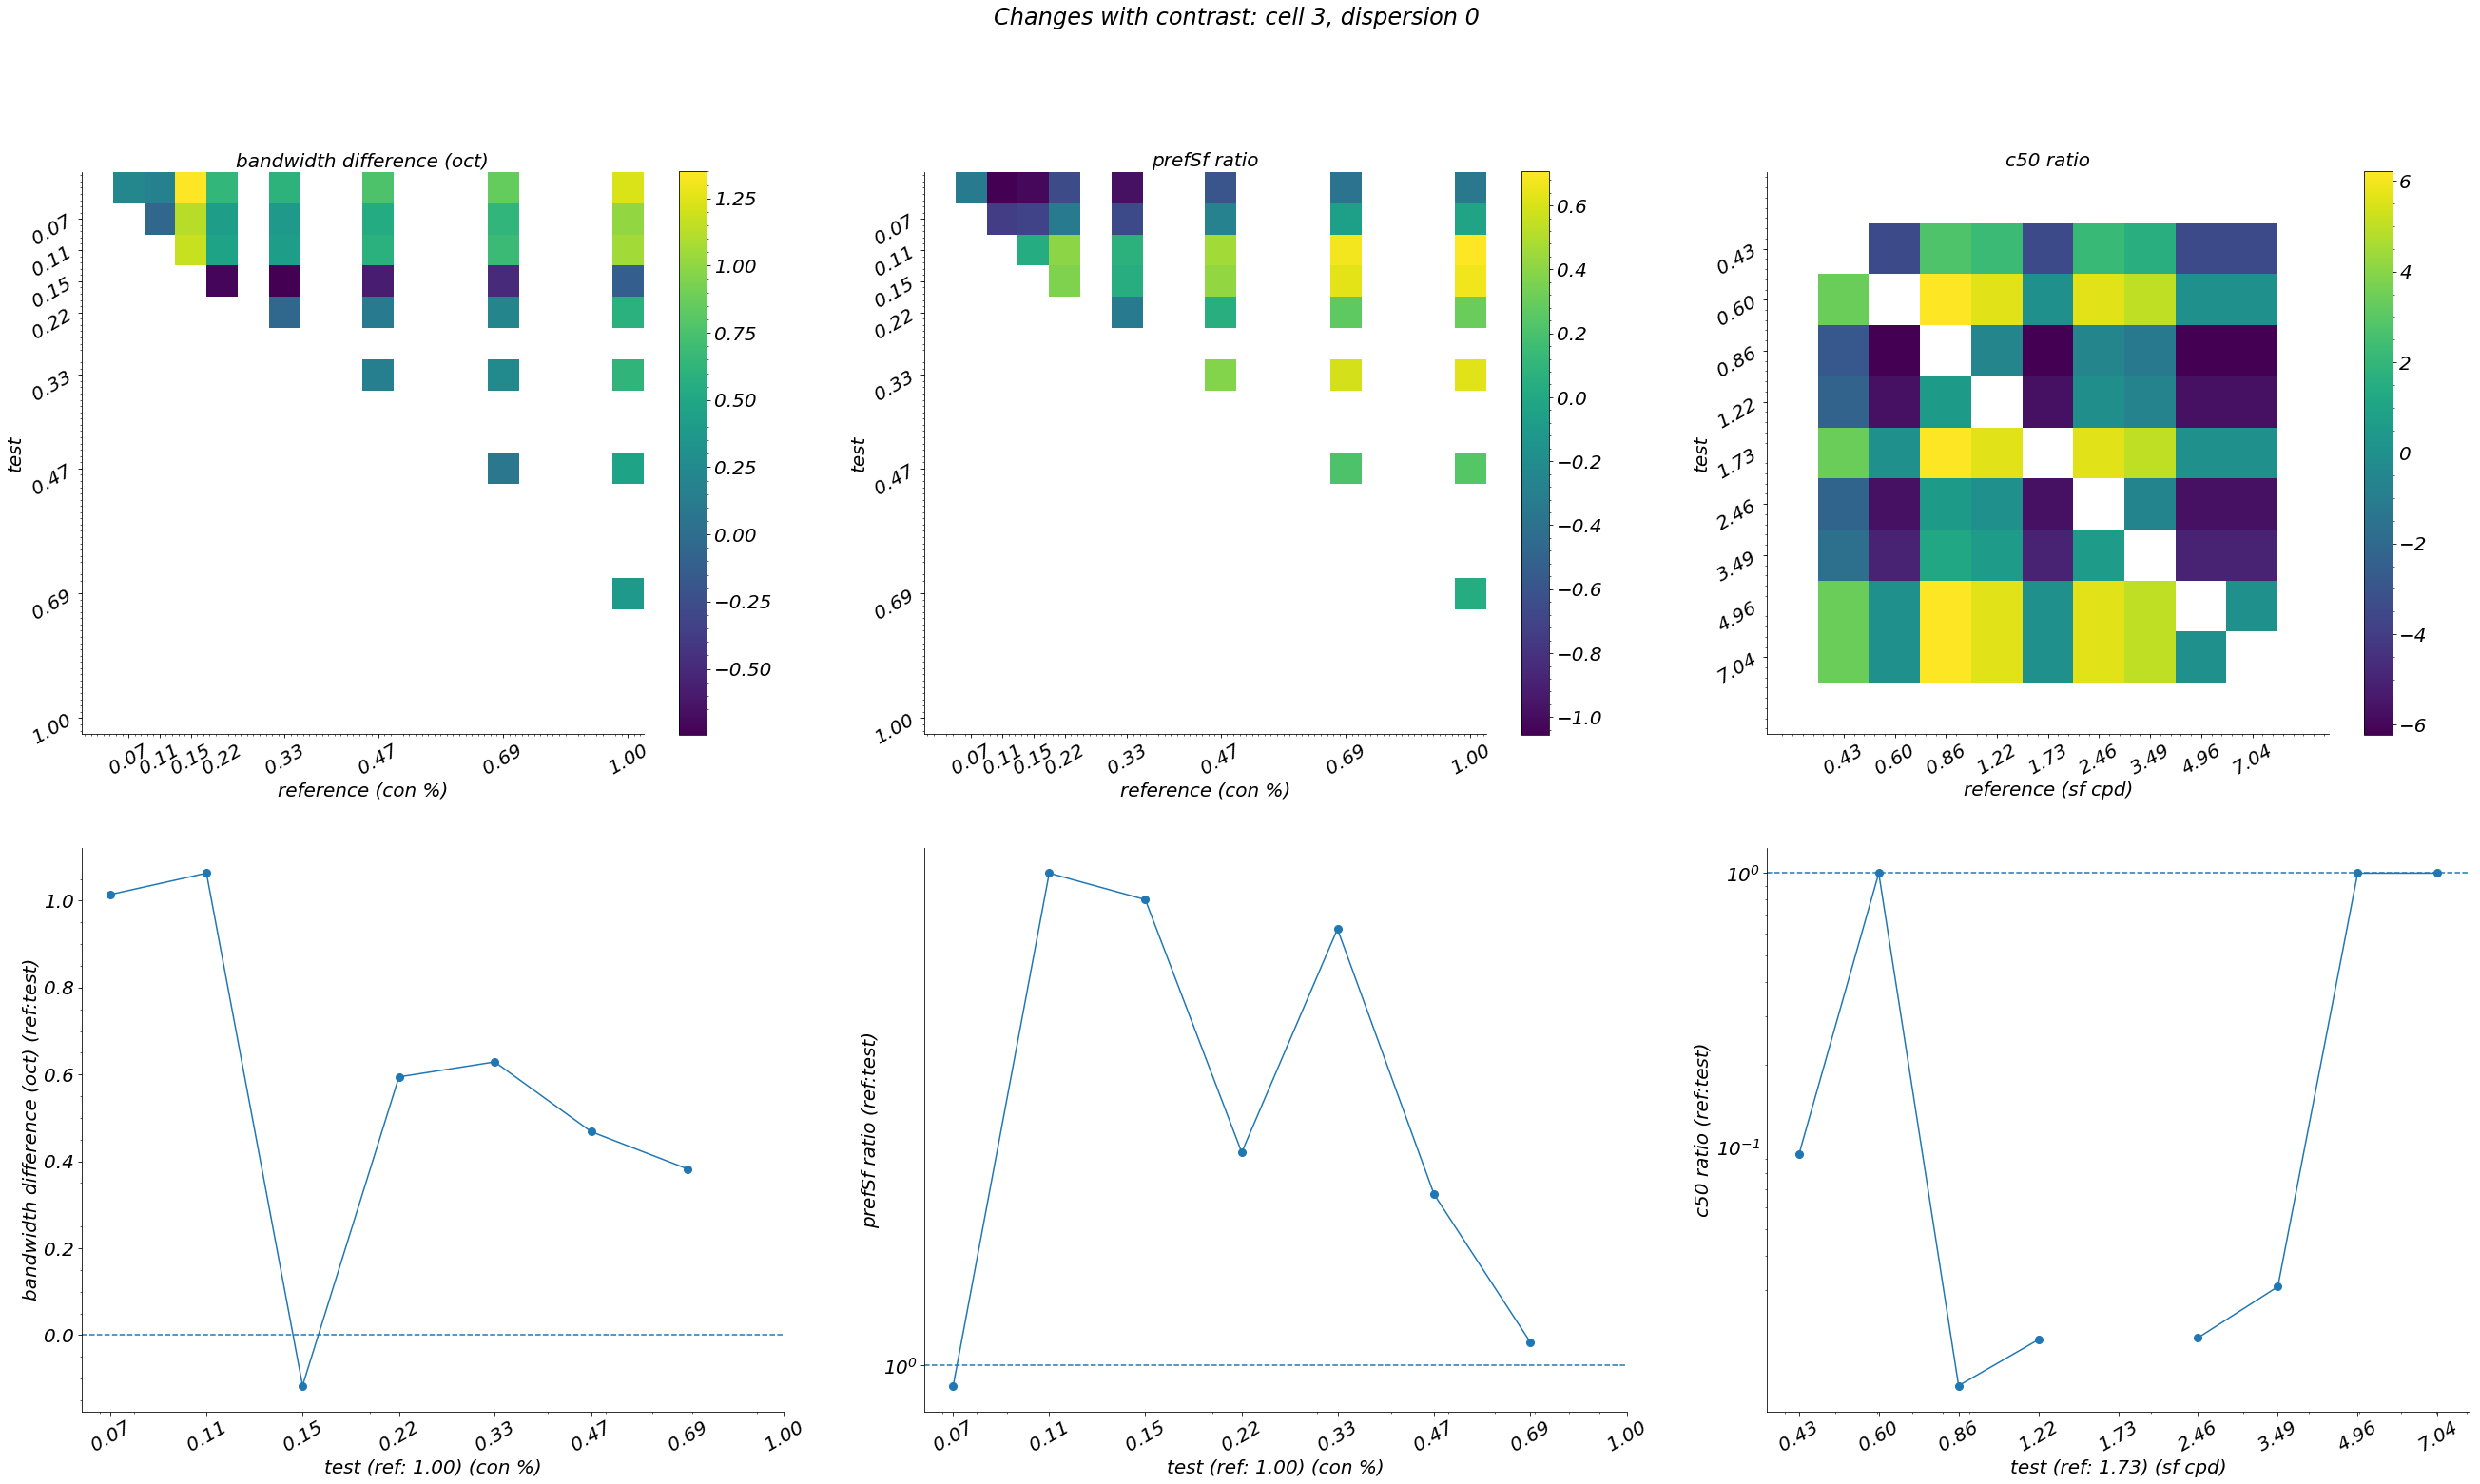

In [870]:

cellNum = 17;
dispInd = 0;

cell = hf.np_smart_load(data_loc + dataList['unitName'][cellNum-1] + '_sfm.npy');
expInd = hf.get_exp_ind(data_loc, dataList['unitName'][cellNum-1])[0];
_, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(cell, expInd);
all_disp, all_con, all_sf = stimVals;

metrics = [bwExpRats, pSfExpRats, c50ExpRats];
metricNames = ['bandwidth difference (oct)', 'prefSf ratio', 'c50 ratio'];
metricUnits = ['(con %)', '(con %)', '(sf cpd)']
metricScales = [all_con, all_con, all_sf];
metricLog    = [0, 1, 1]; # do not log bw diff, but log other measures
metricRef    = [0, 1, 1]; # what is the reference value
nPlots = len(metrics);

f, ax = plt.subplots(2, nPlots, figsize=(15*nPlots, 2*12))

for m, mn, ms, mu, ml, mr, ind in zip(metrics, metricNames, metricScales, metricUnits, metricLog, metricRef, range(nPlots)):

    ### First, the overall summaries
    if ml == 1:
        imCurr = ax[0, ind].imshow(np.log2(m[cellNum-1, dispInd, :, :]));
    elif ml == 0:
        imCurr = ax[0, ind].imshow(m[cellNum-1, dispInd, :, :]);
    ax[0, ind].set_xlabel('reference %s' % mu)
    ax[0, ind].set_ylabel('test')
    # find out which are valid indices
    valids = np.where(np.any(~np.isnan(m[cellNum-1, dispInd, :, :]), 0))[0]
    ax[0, ind].xaxis.set_ticks(valids)
    ax[0, ind].yaxis.set_ticks(valids)
    ax[0, ind].xaxis.set_ticklabels(['%.2f' % x for x in ms[valids]], rotation='30')
    ax[0, ind].yaxis.set_ticklabels(['%.2f' % x for x in ms[valids]], rotation='30')
    f.colorbar(imCurr, ax=ax[0, ind]);
    ax[0, ind].set_title('%s' % mn);
    
    ### Then, the ratio plots for the "preferred" case (i.e. highest con, peakSf)
    # all of the plots here should be w.r.t. log(x)
    if np.all(ms == all_sf): # find peak SF...
        peakSf = pSfExp[ind, dispInd, val_con_by_disp[dispInd][-1]]; # i.e. highest contrast
        peakInd = np.argmin(np.square(ms[valids] - peakSf));
        peakInd = valids[peakInd];
    else:
        peakInd = valids[-1]; # i.e. the highest contrast
    if ml == 1:
        ax[1, ind].loglog(ms[valids], m[cellNum-1, dispInd, valids, peakInd], 'o-')
    elif ml == 0:
        ax[1, ind].semilogx(ms[valids], m[cellNum-1, dispInd, valids, peakInd], 'o-')
    # set the reference line
    ax[1, ind].axhline(mr, linestyle='--')
    # set the axes...
    ax[1, ind].xaxis.set_ticks(ms[valids])
    ax[1, ind].xaxis.set_ticklabels(['%.2f' % x for x in ms[valids]], rotation='30')
    # labels
    ax[1, ind].set_xlabel('test (ref: %.2f) %s' % (ms[peakInd], mu))
    ax[1, ind].set_ylabel('%s (ref:test)' % mn)
    
f.suptitle('Changes with contrast: cell %d, dispersion %d' % (cellInd, dispInd));

In [150]:
# from the old way...
bwDiffMod = bwMod[:, :, conInd[1]] - bwMod[:,:, conInd[0]]
bwDiffExp = bwExp[:, :, conInd[1]] - bwExp[:,:, conInd[0]]

pSfRatioMod = pSfMod[:, :, conInd[1]] / pSfMod[:,:, conInd[0]]
pSfRatioExp = pSfExp[:, :, conInd[1]] / pSfExp[:,:, conInd[0]]

### Considering responsivity at low contrast & high dispersion

Inspired by chats with Najib, I should ensure that the effect of dispersion on contrast dependent shifts holds if we look only at cells with meaningful responses at the low contrast, maximal dispersion case.

In [880]:
crit = 0; # 0 - peak crit, 1 - ratio crit

useLowRespCut = 0; # should you filter the data based on analysis in "Considering responsivity..."

peakCrit = 3; # i.e. cells with maximum response at low con/high disp condition below this won't be counted
# ratCrit = 0.075; # i.e. cells whose sum of responses '''''' as a fraction of the same at high con/low disp won't be counted

In [881]:
# laod all data, get responses
respsAll = np.zeros((nCells, nFamilies, nSfs, nCons)) * np.nan
for i in range(nCells):
    try:
        # load cell
        print('loading cell %d' % int(i+1))
        cellName = dataList['unitName'][i];
        expInd = hf.get_exp_ind(data_loc, cellName)[0]
        S = hf.np_smart_load(data_loc + cellName + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];
        ### organize responses
        _, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(expData, expInd);
        rvcFits = hf.get_rvc_fits(data_loc, expInd, i+1, rvcName='None');
        spikes  = hf.get_spikes(expData, rvcFits=rvcFits, expInd=expInd);
        _, _, respOrg, respAll    = hf.organize_resp(spikes, expData, expInd);

        respMean = respOrg;
        respStd = np.nanstd(respAll, -1); # take std of all responses for a given condition
        # compute SEM, too
        findNaN = np.isnan(respAll);
        nonNaN  = np.sum(findNaN == False, axis=-1);
        respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);

        respsAll[i, :, :, :] = respMean;
    except:
        warnings.warn('Could not properly get responses for cell %d' % np.int(i+1))

loading cell 1


/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Could not properly get responses for cell 1


loading cell 2
loading cell 3
loading cell 4
loading cell 5
loading cell 6
loading cell 7
loading cell 8
loading cell 9
loading cell 10
loading cell 11
loading cell 12
loading cell 13
loading cell 14
loading cell 15
loading cell 16
loading cell 17


In [873]:
nCells = len(dataList['unitName']);
peaks = np.zeros((nCells, 2)); # do (, 2) so we can compare high con/low disp to low con/high disp
sums = np.zeros((nCells, 2));

for c in range(nCells):
    responses = respsAll[c, :, :, :];

    peaks[c, 0] = np.amax(responses[0, :, -1]); # peak response for single grating, high contrast
    sums[c, 0] = np.sum(responses[0, :, -1]);

    peaks[c, 1] = np.amax(responses[nFamilies-1, :, 0]); # ' ' for maximum dispersion, low contrast
    sums[c, 1] = np.sum(responses[nFamilies-1, :, 0]);

rats = np.divide(sums[:, 1], sums[:, 0]);

In [875]:
if useLowRespCut:
    # what's the criteri(a/on)?
    if crit == 0:
        keepCells = peaks[:, 1] > peakCrit;
    elif crit == 1:
        keepCells = rats > ratCrit;
    
    bwMod = bwMod[keepCells, :];
    bwExp = bwExp[keepCells, :];
    
    pSfExp = pSfExp[keepCells, :];
    pSfMod = pSfMod[keepCells, :];
    
    bwDiffMod = bwDiffMod[keepCells, :];
    bwDiffExp = bwDiffExp[keepCells, :];

    pSfRatioMod = pSfRatioMod[keepCells, :];
    pSfRatioExp = pSfRatioExp[keepCells, :];

IndexError: boolean index did not match indexed array along dimension 0; dimension is 47 but corresponding boolean dimension is 17

## Overall statistics

That is, plot the mean preferred frequency, bandwidth, etc

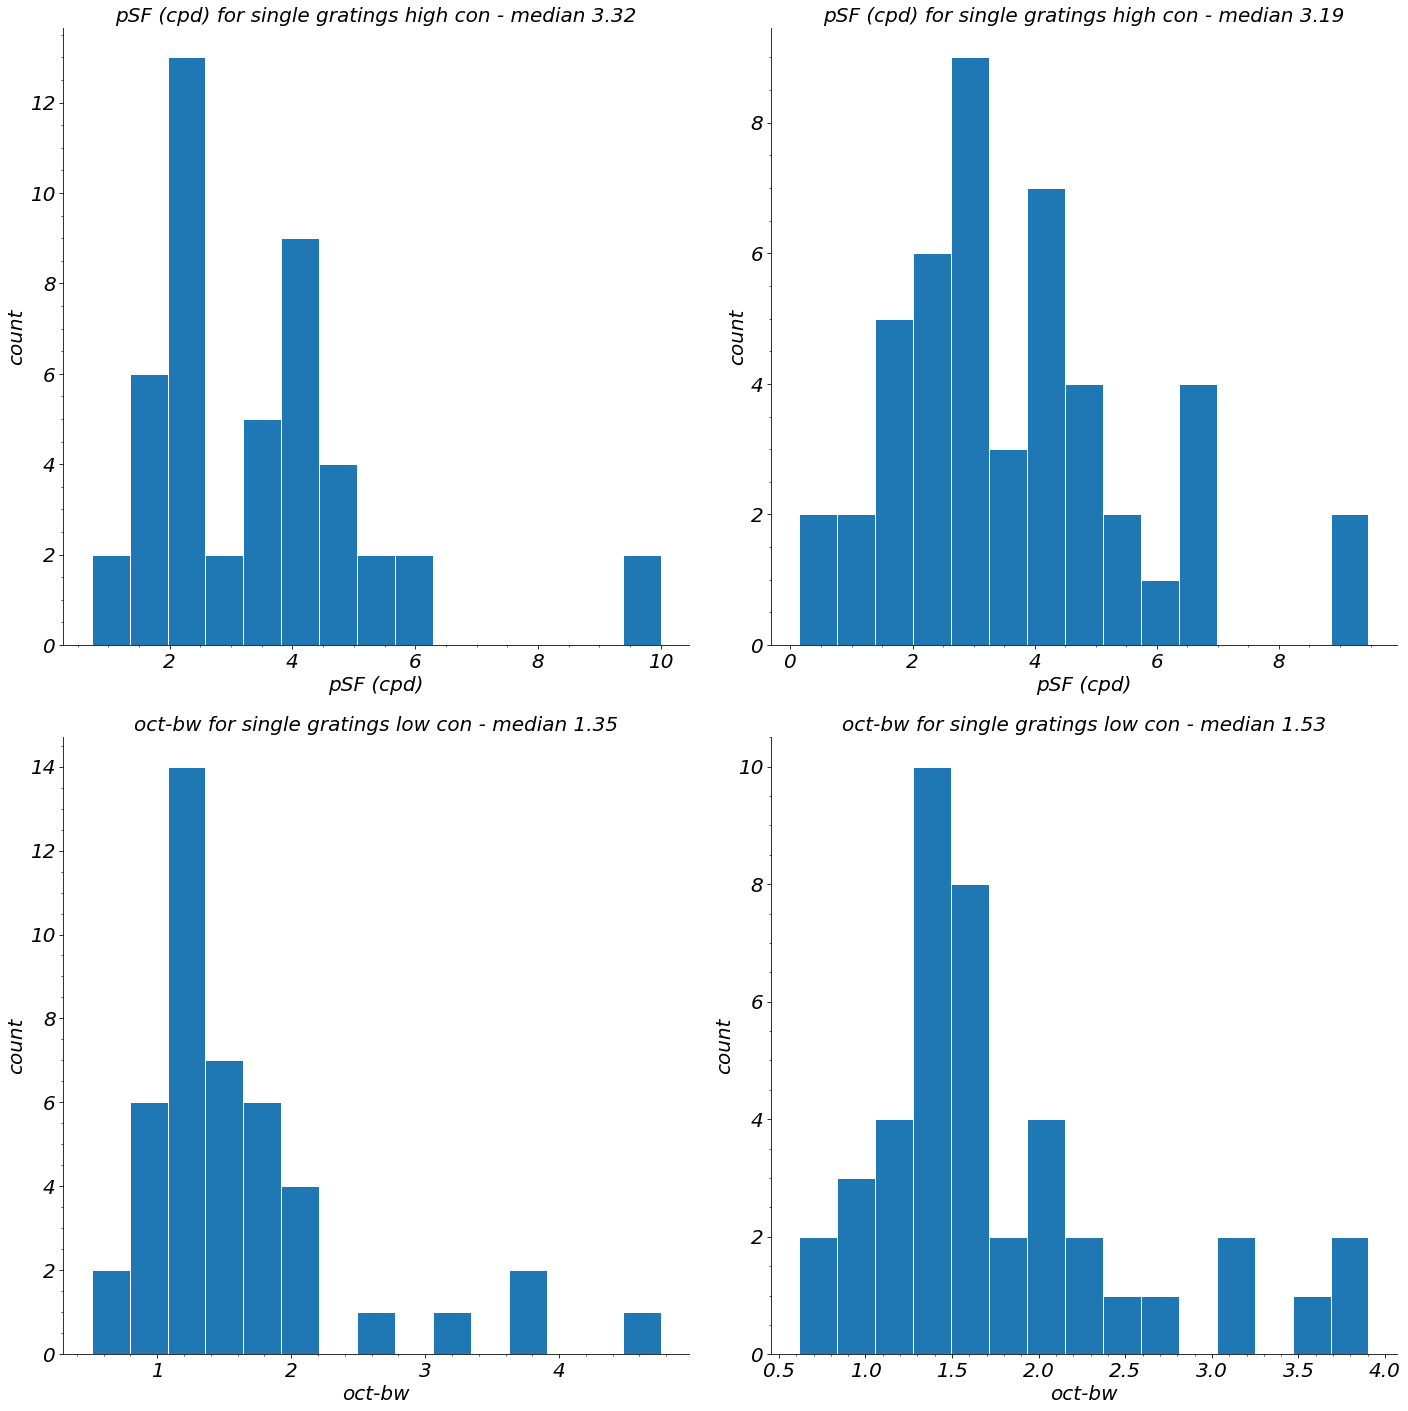

In [155]:
data = [pSfExp, bwExp];
dataStr = ['pSF (cpd)', 'oct-bw'];
conStr = ['high', 'low'];
# scaleStr = ['log', 'linear'];
plt.figure(figsize=(20, 20))
fontsz = 20;
for i in range(len(data)):
    
    curr_data = data[i];
    
    for con in range(2):
        plt.subplot(2, 2, 1+con+2*i)
        not_nan = np.transpose(np.where(~np.isnan(curr_data[:, 0, con])));
        plt.hist(curr_data[not_nan, 0, con], 15);
        plt.xticks(fontsize=20); plt.yticks(fontsize=fontsz);
        plt.xlabel('%s' % (dataStr[i]), fontsize=fontsz);
        plt.ylabel('count', fontsize=fontsz);
        plt.title('%s for single gratings %s con - median %.2f' % (dataStr[i], conStr[i], np.nanmedian(curr_data[:, 0, con])), fontsize=fontsz);
    
plt.tight_layout()

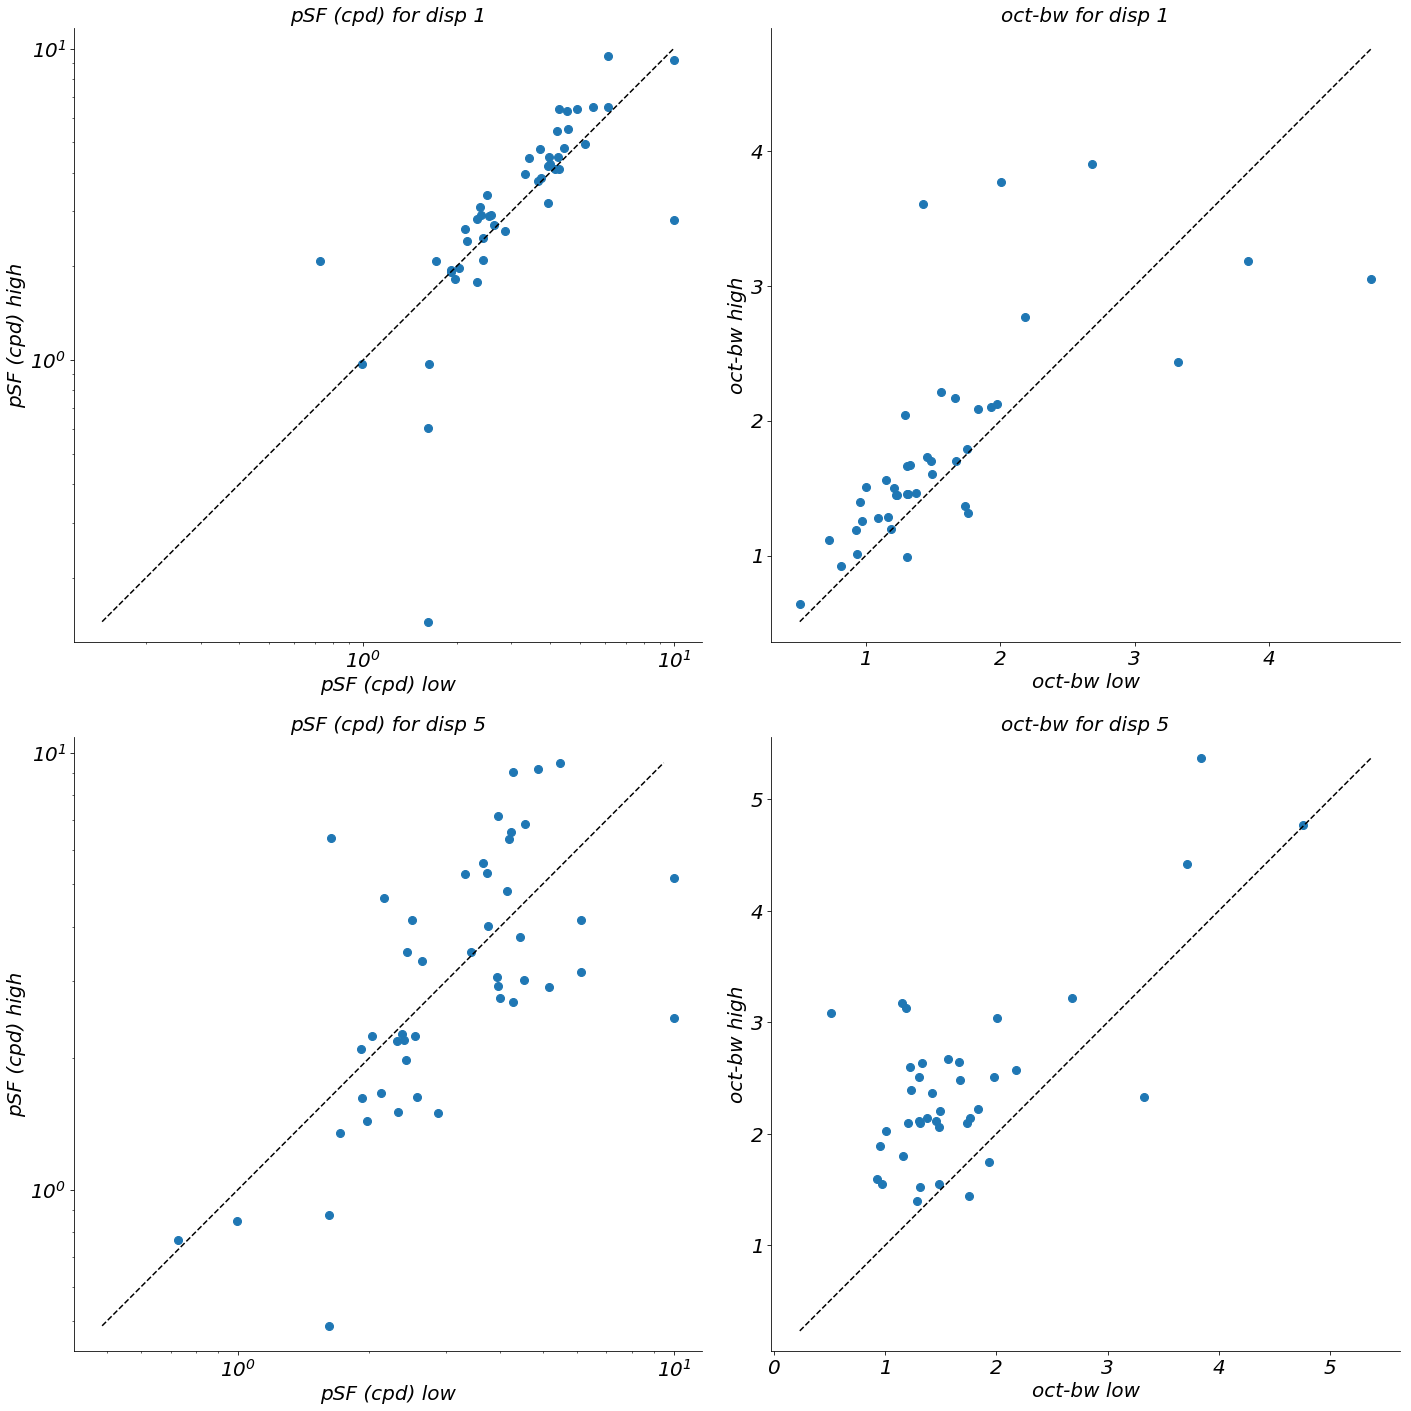

In [145]:
disp = [0, 4];
data = [pSfExp, bwExp];
dataStr = ['pSF (cpd)', 'oct-bw'];
conInd  = [nCons-1, 0]; # high, low
conStr =  ['high', 'low']
scaleStr = ['log', 'linear'];
plt.figure(figsize=(20, 20))
fontsz = 20;


for d in range(len(disp)):

    for i in range(len(data)):

        curr_data = data[i];

        plt.subplot(2, 2, 1+i+2*d)
        not_nan = np.transpose(np.where(~np.isnan(curr_data[:, disp[d], 0]) & ~np.isnan(curr_data[:, disp[d], 1])))
        plt.plot(curr_data[not_nan, 0, conInd[1]], curr_data[not_nan, disp[d], conInd[0]], 'o');

        plt_min = np.min(np.minimum(curr_data[not_nan, disp[d], 0], curr_data[not_nan, disp[d], 1]));
        plt_max = np.max(np.maximum(curr_data[not_nan, disp[d], 0], curr_data[not_nan, disp[d], 1]));
        plt.plot([plt_min, plt_max], [plt_min, plt_max], 'k--')

        plt.xticks(fontsize=20); plt.yticks(fontsize=fontsz);
        plt.xlabel('%s %s' % (dataStr[i], conStr[1]), fontsize=fontsz);
        plt.ylabel('%s %s' % (dataStr[i], conStr[0]), fontsize=fontsz);
        plt.title('%s for disp %d' % (dataStr[i], disp[d]+1), fontsize=fontsz);
        plt.xscale(scaleStr[i]);
        plt.yscale(scaleStr[i]);
        plt.axis('equal')
    
plt.tight_layout()

### Plot BW differences

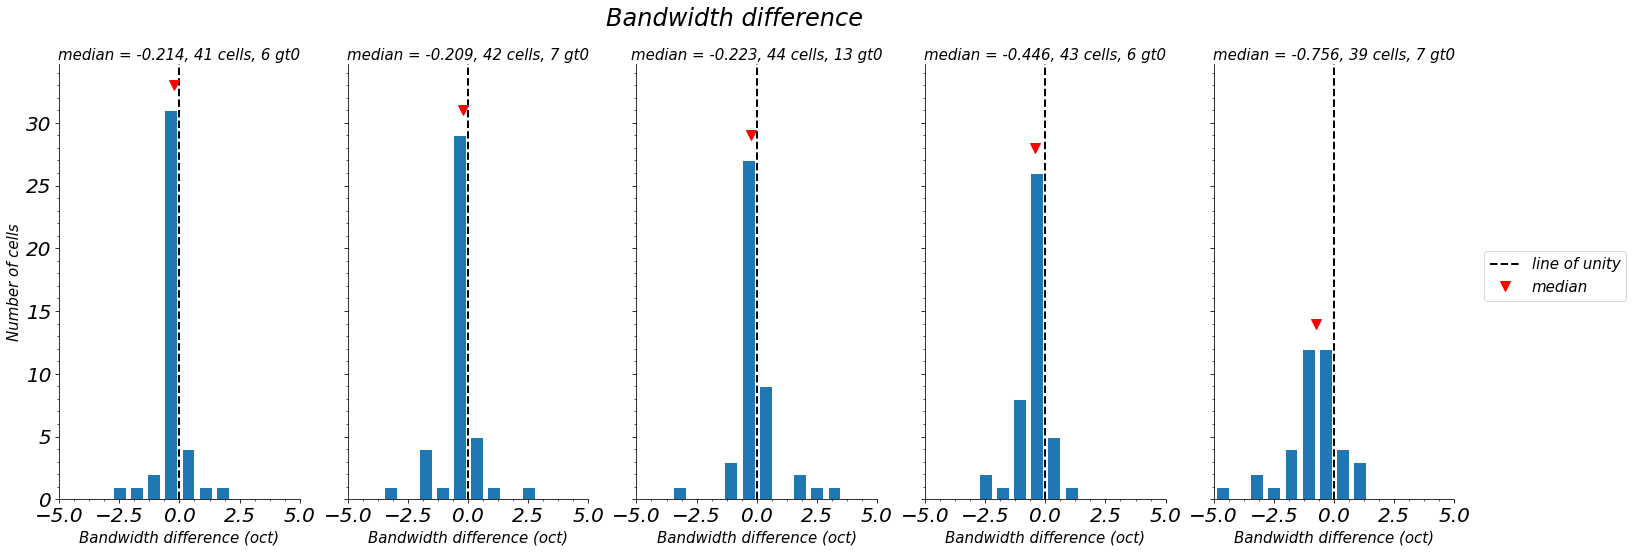

In [146]:
fig, allBW = plt.subplots(1, nFamilies, sharex='col', sharey='row', figsize=(25,8))

allBW[0].set_ylabel('Number of cells', fontsize=15);
binRange = (-5, 5)
nBins = 15;
binz = np.linspace(binRange[0], binRange[1], num=nBins);

for fam in range(nFamilies):
    validOnesExp = np.logical_and(bwDiffExp[:,fam]>-5, pSfRatioExp[:,fam]<5);
    toConsider = bwDiffExp[validOnesExp, fam];
    countz = allBW[fam].hist(toConsider, binz, alpha=1, rwidth=0.75);
    
    medianRatio = np.median(toConsider);
    allBW[fam].hold;
    
    unity = allBW[fam].axvline(0, ls='--', color='k', linewidth=2);
    medPt = allBW[fam].plot(medianRatio, np.amax(countz[0])+2, 'rv', markersize=10);
    
    allBW[fam].set_xlabel('Bandwidth difference (oct)', fontsize=15);
    allBW[fam].set_xlim(binRange);
    
    allBW[fam].text(0.5, 1.01,'median = {:.3f}, {:.0f} cells, {:.0f} gt0'.format(medianRatio, sum(countz[0]), sum(bwDiffExp[:, fam]>=0)), horizontalalignment='center',\
                     transform=allBW[fam].transAxes, FontSize=15)
    
fig.legend((unity, medPt[0]), ('line of unity', 'median'), fontsize=15, loc='right');
plt.suptitle('Bandwidth difference', fontsize=24);

### Plot pSf ratios

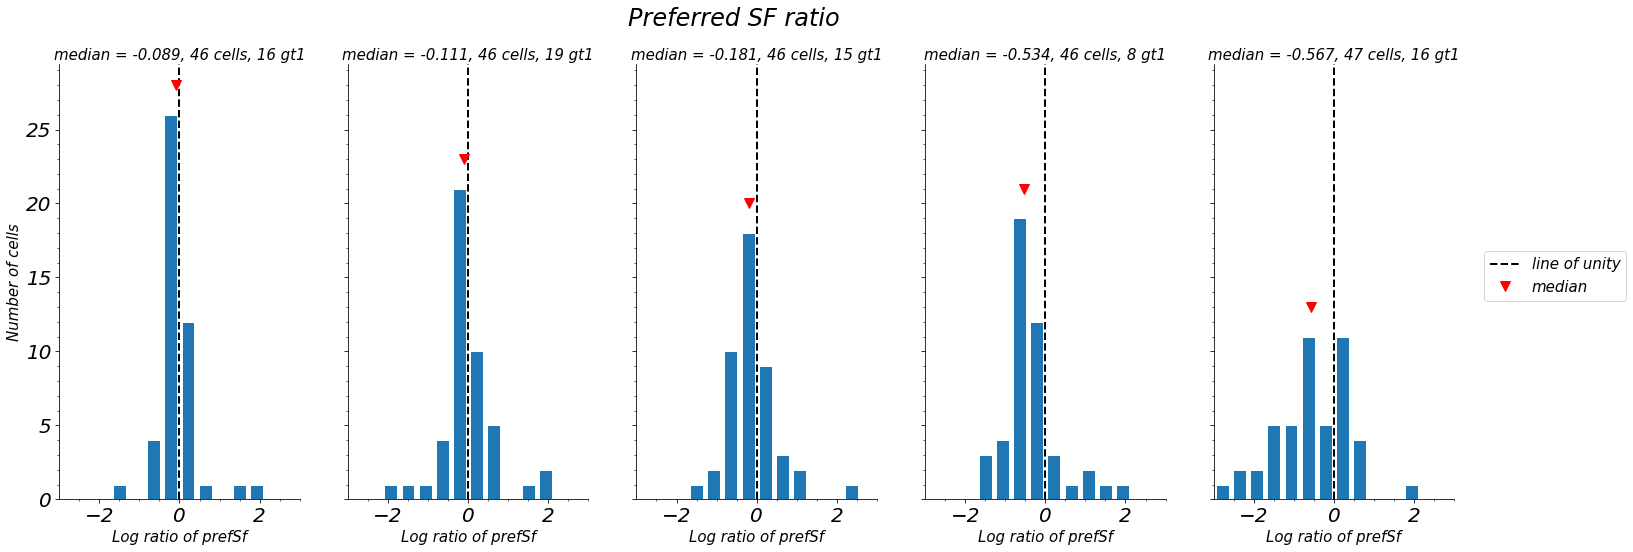

In [147]:
fig, allpSf = plt.subplots(1, nFamilies, sharex='col', sharey='row', figsize=(25,8))

allpSf[0].set_ylabel('Number of cells', fontsize=15)
binRange = (-3, 3) # in log2 space...
nBins = 15;
binz = np.linspace(binRange[0], binRange[1], num=nBins)

for fam in range(nFamilies):
    validOnesExp = np.logical_and(pSfRatioExp[:,fam]>0, pSfRatioExp[:,fam]<10);
    toConsider = np.log2(pSfRatioExp[validOnesExp, fam]);
    countz = allpSf[fam].hist(toConsider, binz, alpha=1, rwidth=0.75)

    medianRatio = np.median(toConsider);
    allpSf[fam].hold

    unity = allpSf[fam].axvline(0, ls='--', color='k', linewidth=2)
    medPt = allpSf[fam].plot(medianRatio, np.amax(countz[0])+2, 'rv', markersize=10)
    
    allpSf[fam].set_xlabel('Log ratio of prefSf', fontsize=15)
    allpSf[fam].set_xlim(binRange)
    
    allpSf[fam].text(0.5, 1.01,'median = {:.3f}, {:.0f} cells, {:.0f} gt1'.format(medianRatio, sum(countz[0]), sum(pSfRatioExp[:, fam]>1)), horizontalalignment='center',\
                     transform=allpSf[fam].transAxes, FontSize=15)
    
fig.legend((unity, medPt[0]), ('line of unity', 'median'), fontsize=15, loc='right');
plt.suptitle('Preferred SF ratio', fontsize=24);

### Nice plot just for single gratings

In [13]:
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

sns.set_style('ticks')

In [14]:
rcParams['xtick.major.size'] = 12
rcParams['xtick.minor.size'] = 8
rcParams['xtick.labelsize'] = 'x-large'

rcParams['ytick.major.size'] = 12
rcParams['ytick.minor.size'] = 8
rcParams['ytick.labelsize'] = 'x-large'

In [15]:
from scipy.stats import norm as normpdf

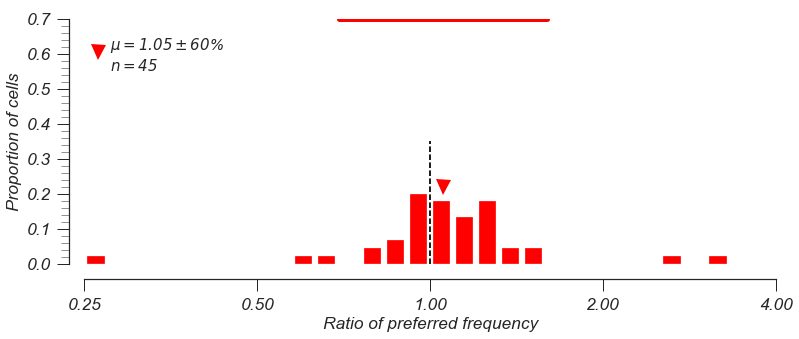

In [16]:
fam = 0; # i.e. single gratings

f, allpSf = plt.subplots(1, 1, figsize=(12,5))

binRange = [-2.0, 2];
nBins = 31;
bins = np.geomspace(np.power(2, binRange[0]), np.power(2, binRange[1]), nBins);

validOnesExp = np.logical_and(pSfRatioExp[:,fam]>0, pSfRatioExp[:,fam]<10);
toConsider = pSfRatioExp[validOnesExp, fam];
wghts = np.ones_like(toConsider)/float(len(toConsider));
countz, _, _ = plt.hist(np.clip(toConsider, bins[0], bins[-1]), bins, alpha=1, rwidth=0.75, weights=wghts, color='r')
unity = plt.axvline(1, ymin=0, ymax=0.5, ls='--', color='k')

gmeanRatio = gmean(toConsider);
stdz = np.std(np.log2(toConsider))
std_as_ratio = stdz/gmeanRatio;
gmnPt = plt.plot(gmeanRatio, 1.1*np.amax(countz), 'rv', markersize=15, label='$\mu = %.2f \pm %.0f$%%\n$n = %d$' % (gmeanRatio, 100*std_as_ratio, len(toConsider)));
plt.plot([np.power(2, -std_as_ratio)*gmeanRatio, np.power(2, std_as_ratio)*gmeanRatio], [0.7, 0.7], 'r-', linewidth=5);
# plt.plot([(1-std_as_ratio)*gmeanRatio, (1+std_as_ratio)*gmeanRatio], [0.7, 0.7], 'r-', linewidth=5);

plt.legend(frameon=False, fontsize=15, handlelength=0, loc='upper left');

plt.xlabel('Ratio of preferred frequency', fontsize='x-large')
plt.xlim([bins[0], bins[-1]])
plt.xscale('log', basex=2)
plt.ylim([0, .7])

allpSf.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.ylabel('Proportion of cells', fontsize='x-large')

sns.despine(offset=15)
f.subplots_adjust(bottom=0.2, left=0.1);

saveName = "/prefSf_v1.pdf"
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

"Imported" characteristic frequencies from the LGN dataset (for 3rd year talk; early-mid October, 2018)

In [24]:
lgn_charFreq = [1.0020451737501732,
 1.0206556734821166,
 1.0257681309942968,
 1.04480874143425,
 1.0000000165613674,
 1.027137394071815,
 1.037631054868214,
 1.08396854127822,
 1.00001257163969,
 0.9999980090339309,
 1.0519356235443083,
 1.0936839960176619,
 1.0003166344527543,
 0.9564302135458911,
 1.0033907306187635,
 1.212693120340718,
 1.0333203056368454,
 1.1935486130772168,
 1.1619733754350887,
 1.2184740928804894,
 0.9988305540449457,
 1.1837072043400947,
 1.1356436666284924,
 2.9006418155334814,
 1.4746481972195455,
 1.0596841709560518,
 1.0095553647533309,
 1.0000000075798183,
 1.2968888714737625,
 1.0465686567933,
 1.1394417646254775,
 1.0192137069261848,
 1.2841141410283319,
 0.839166213863962,
 0.8744343531054689,
 1.5501803852669327,
 1.049637210506345,
 0.5439252203168028,
 0.7733022737395222,
 1.1060521853816636,
 0.7169208761024872,
 0.7766654036335691,
 0.8435748796878028,
 0.802552853552545,
 0.861311395020923,
 1.0572338326266482,
 1.091777878359758,
 1.212658767225073,
 0.8747744742343209,
 0.870496989888369,
 1.2325501298692372,
 0.9691747527973583]

In [25]:
from scipy.stats import ks_2samp

In [31]:
# comparing the distributions - LGN vs V1...
ks_2samp(rats, toConsider)

Ks_2sampResult(statistic=0.8994350282485876, pvalue=2.196750918325969e-19)

### Relationship between prefSf and sfBW (octaves)

In [ ]:
fig, prefVbw = plt.subplots(2, 2, figsize = (12, 12));

pSfLow = pSfExp[:, 0, 0]; # pSf at low dispersion, high contrast
pSfHigh = pSfExp[:, 4, 0]; # pSf at high dispersion, high contrast

sfBwLow = bwExp[:, 0, 0]; # pSf at low dispersion, high contrast
sfBwHigh = bwExp[:, 4, 0]; # pSf at high dispersion, high contrast

# Low versus Low
prefVbw[0, 0].semilogx(pSfLow, sfBwLow, 'o', mec='white');
prefVbw[0, 0].set_xlabel('preferred SF (cpd)');
prefVbw[0, 0].set_ylabel('bandwidth (oct)');
prefVbw[0, 0].set_title('Low dispersion');

# Low versus High
prefVbw[1, 0].semilogx(pSfLow, sfBwHigh, 'o', mec='white');
prefVbw[1, 0].set_xlabel('preferred SF (cpd)');
prefVbw[1, 0].set_ylabel('bandwidth (oct)');
prefVbw[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
prefVbw[0, 1].semilogx(pSfHigh, sfBwLow, 'o', mec='white');
prefVbw[0, 1].set_xlabel('preferred SF (cpd)');
prefVbw[0, 1].set_ylabel('bandwidth (oct)');
prefVbw[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
prefVbw[1, 1].semilogx(pSfHigh, sfBwHigh, 'o', mec='white');
prefVbw[1, 1].set_xlabel('preferred SF (cpd)');
prefVbw[1, 1].set_ylabel('bandwidth (oct)');
prefVbw[1, 1].set_title('High dispersion');


### Relationship between prefSf and sfBw (linear cpd)

Just a sanity check for correlation between prefSf and linear bandwidth

In [ ]:
fig, prefVbw = plt.subplots(2, 2, figsize = (12, 12));

pSfLow = pSfExp[:, 0, 0]; # pSf at low dispersion, high contrast
pSfHigh = pSfExp[:, 4, 0]; # pSf at high dispersion, high contrast

sfBwLow = bwExp[:, 0, 0]; # pSf at low dispersion, high contrast
sfBwHigh = bwExp[:, 4, 0]; # pSf at high dispersion, high contrast

linLow = hfunc.bw_log_to_lin(sfBwLow, pSfLow);
linHigh = hfunc.bw_log_to_lin(sfBwHigh, pSfHigh);

# Low versus Low
prefVbw[0, 0].plot(pSfLow, linLow[0], 'o', mec='white');
prefVbw[0, 0].set_xlabel('preferred SF (cpd)');
prefVbw[0, 0].set_ylabel('bandwidth (cpd)');
prefVbw[0, 0].set_title('Low dispersion');

# Low versus High
prefVbw[1, 0].plot(pSfLow, linHigh[0], 'o', mec='white');
prefVbw[1, 0].set_xlabel('preferred SF (cpd)');
prefVbw[1, 0].set_ylabel('bandwidth (cpd)');
prefVbw[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
prefVbw[0, 1].plot(pSfHigh, linLow[0], 'o', mec='white');
prefVbw[0, 1].set_xlabel('preferred SF (cpd)');
prefVbw[0, 1].set_ylabel('bandwidth (cpd)');
prefVbw[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
prefVbw[1, 1].plot(pSfHigh, linHigh[0], 'o', mec='white');
prefVbw[1, 1].set_xlabel('preferred SF (cpd)');
prefVbw[1, 1].set_ylabel('bandwidth (cpd)');
prefVbw[1, 1].set_title('High dispersion');


### Correlations between preferred SF and ratio of pSf high/low

In [ ]:
fig, pSfCorr = plt.subplots(2, 2, figsize = (12, 12));

pSfLow = pSfExp[:, 0, 0]; # pSf at low dispersion, high contrast
pSfShiftLow = pSfRatioExp[:, 0]; # ratio of pSf at high/low contrast for low dispersion

pSfHigh = pSfExp[:, 4, 0]; # pSf at high dispersion, high contrast
pSfShiftHigh = pSfRatioExp[:, 4]; # ratio of pSf at high/low contrast for high dispersion

# Low versus Low
pSfCorr[0, 0].semilogx(pSfLow, pSfShiftLow, 'o', mec='white');
pSfCorr[0, 0].set_xlabel('preferred SF (cpd)');
pSfCorr[0, 0].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[0, 0].set_title('Low dispersion');

# Low versus High
pSfCorr[1, 0].semilogx(pSfLow, pSfShiftHigh, 'o', mec='white');
pSfCorr[1, 0].set_xlabel('preferred SF (cpd)');
pSfCorr[1, 0].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
pSfCorr[0, 1].semilogx(pSfHigh, pSfShiftLow, 'o', mec='white');
pSfCorr[0, 1].set_xlabel('preferred SF (cpd)');
pSfCorr[0, 1].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
pSfCorr[1, 1].semilogx(pSfHigh, pSfShiftHigh, 'o', mec='white');
pSfCorr[1, 1].set_xlabel('preferred SF (cpd)');
pSfCorr[1, 1].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[1, 1].set_title('High dispersion');


### Correlations between measured BW and difference of bandwidth high-low (oct)

In [ ]:
fig, sfBwCorr = plt.subplots(2, 2, figsize = (12, 12));

sfBwLow = bwExp[:, 0, 0]; # pSf at low dispersion, high contrast
sfBwShiftLow = bwDiffExp[:, 0]; # ratio of pSf at high/low contrast for low dispersion

sfBwHigh = bwExp[:, 4, 0]; # pSf at high dispersion, high contrast
sfBwShiftHigh = bwDiffExp[:, 4]; # ratio of pSf at high/low contrast for high dispersion

# Low versus Low
sfBwCorr[0, 0].plot(sfBwLow, sfBwShiftLow, 'o', mec='white');
sfBwCorr[0, 0].set_xlabel('sfBw (oct)');
sfBwCorr[0, 0].set_ylabel('Difference in  bw oct (High-Low)');
sfBwCorr[0, 0].set_title('Low dispersion');

# Low versus High
sfBwCorr[1, 0].plot(sfBwLow, sfBwShiftHigh, 'o', mec='white');
sfBwCorr[1, 0].set_xlabel('sfBw (oct)');
sfBwCorr[1, 0].set_ylabel('Difference in  bw oct (High-Low)');
sfBwCorr[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
sfBwCorr[0, 1].plot(sfBwHigh, sfBwShiftLow, 'o', mec='white');
sfBwCorr[0, 1].set_xlabel('sfBw (oct)');
sfBwCorr[0, 1].set_ylabel('Difference in  bw oct (High-Low)');
sfBwCorr[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
sfBwCorr[1, 1].plot(sfBwHigh, sfBwShiftHigh, 'o', mec='white');
sfBwCorr[1, 1].set_xlabel('sfBw (oct)');
sfBwCorr[1, 1].set_ylabel('Difference in  bw oct (High-Low)');
sfBwCorr[1, 1].set_title('High dispersion');


## SfN 2018?

Quickly, on 5/3 (day of abstract deadline), let's see if the "tuned" normalization in the model accounts for the contrast-dependent shifts in SF tuning, and in exactly what way

In [ ]:
save_loc = '../Figures/SFN/'; save_name = 'cotuning.pdf';

In [ ]:
filterSF = 0; # where in parameter array
normSF = -2; # where in parameter array

What are the relative preferences of the filter and the normalization pool?

In [ ]:
filt_vals = np.zeros((len(modParams), 1));
norm_vals = np.zeros((len(modParams), 1));
ratios = np.zeros((len(modParams), 1));
under_list = [];
for i in modParams:
    fv = modParams[i]['params'][filterSF];
    nv = np.exp(modParams[i]['params'][normSF])
    filt_vals[i] = fv;
    norm_vals[i] = nv;
    ratios[i] = nv/fv;
    if nv < fv:
        #print('cell %d' % (i+1))
        under_list.append(i);

sfn = plt.figure(figsize=(40, 10))

y = plt.subplot(1, 3, 1);
plt.loglog(filt_vals, norm_vals, 'b.');
#plt.loglog(filt_vals[under_list], norm_vals[under_list], 'r.');
plt.loglog([1e-2, 1e2], [1e-2, 1e2], 'k--');
plt.xlabel('Filter preferred SF (cpd)', fontSize = 'large');
plt.ylabel('Norm pool preferred SF (cpd)', fontSize = 'large');
below_unity = np.sum(ratios<=1) / len(ratios)
plt.title('Relationship between filter and normalization tuning - %.1f%% below unity' % (100*below_unity), fontSize = 'large');

plt.subplot(1, 3, 2);
plt.loglog(filt_vals, ratios, 'b.');
plt.loglog([1e-2, 1e2], [1, 1], 'k--');
plt.xlabel('Filter preferred SF (cpd)', fontSize = 'large');
plt.ylabel('Ratio (norm/filter)', fontSize = 'large');
gmRatio = gmean(ratios)
plt.title('Relationship between filter and normalization tuning - geomean %.2f' % (gmRatio), fontSize = 'large');

# as CDF
cdf_rats = np.argsort(ratios.transpose())[0];
plt.subplot(1, 3, 3);
plt.semilogy(range(len(cdf_rats)), ratios[cdf_rats], 'b.');
plt.semilogy([1, len(cdf_rats)], [1, 1], 'k--');
plt.xlabel('Rank', fontSize = 'large');
plt.ylabel('Ratio (norm/filter)', fontSize = 'large');
gmRatio = gmean(ratios)
plt.title('CDF of norm/filter ratios - geomean %.2f' % (gmRatio), fontSize = 'large');

# save
pdfSv = pltSave.PdfPages(str(save_loc + save_name));
pdfSv.savefig(sfn)
pdfSv.close();


Next, list the cells in ascending order of ratio

In [ ]:
asc_rats = np.argsort(ratios.transpose());
for i in range(len(asc_rats[0])):
    print('%d: %.3f' % (asc_rats[0][i]+1, ratios[asc_rats[0][i]]))